In [112]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns 
import scipy
import matplotlib.cbook as cbook
import csv

In [19]:
data_2 = pd.read_csv('/Users/rebeccawagner/Desktop/new_seg_100_200_300_400_50000all')
data_2 = data_2.set_index('Unnamed: 0')
data_2.index.name = None
data_2.columns = [int(x) for x in data_2.columns]
data_2.columns = [x+100000 for x in data_2.columns]

seg_data = pd.read_csv("/Users/rebeccawagner/Desktop/Seg_100_200_300_400_500_600_700_800_900_100000all")
seg_data = seg_data.set_index('Unnamed: 0')
seg_data.index.name = None
original_sores = seg_data["1"]
seg_data = seg_data.drop(columns="1")

new_data = seg_data.merge(right=data_2, right_index=True,left_index=True)
seg_scores = np.sort(new_data.stack().values)

In [20]:
## Boxplot Settings ====================

# Number of iterations to compare for each set of boxes
#steps = [100, 1000, 10000]
n_trials = 150000
n_dists = 7

n_steps = 5
steps = np.logspace(2, np.log10(n_trials), n_steps).astype(int)

# Settings for whiskers

# Default - 1.5 of IQR
whis = 1.5

# 1st and 99th percentiles
#whis = [1, 99]

# Min and max
#whis = [0, 100]

# Boxplot properties
#      more examples: https://matplotlib.org/3.1.1/gallery/statistics/boxplot.html

flierprops = dict(marker='.', 
                  markersize=0) # Setting to 0 turns fliers off

medianprops = dict(linestyle='-',
                   color='k')

boxprops = dict(color='k')

## KDE settings

# Have the opportunity to get more granular here
n_steps_kde = 10
kde_steps = np.logspace(2, np.log10(n_trials), n_steps_kde).astype(int)


In [21]:
steps, kde_steps

(array([   100,    622,   3872,  24102, 150000]),
 array([   100,    225,    507,   1144,   2579,   5814,  13103,  29532,
         66556, 150000]))

In [22]:
stats = []
for s in steps:
    stats.append(cbook.boxplot_stats(new_data.iloc[:,0:int(s)].T, whis = whis))

In [40]:
colors = ['cornflowerblue','teal','red','darkorange','rebeccapurple']

import matplotlib.patches as mpatches

patch_1 = mpatches.Patch(color='cornflowerblue', label='100 Iterations')
patch_2 = mpatches.Patch(color='teal', label='622 Iterations')
patch_3 = mpatches.Patch(color='red', label='3,872 Iterations')
patch_4 = mpatches.Patch(color='darkorange', label='24,102 Iterations')
patch_5 = mpatches.Patch(color='rebeccapurple', label='150,000 Iterations')


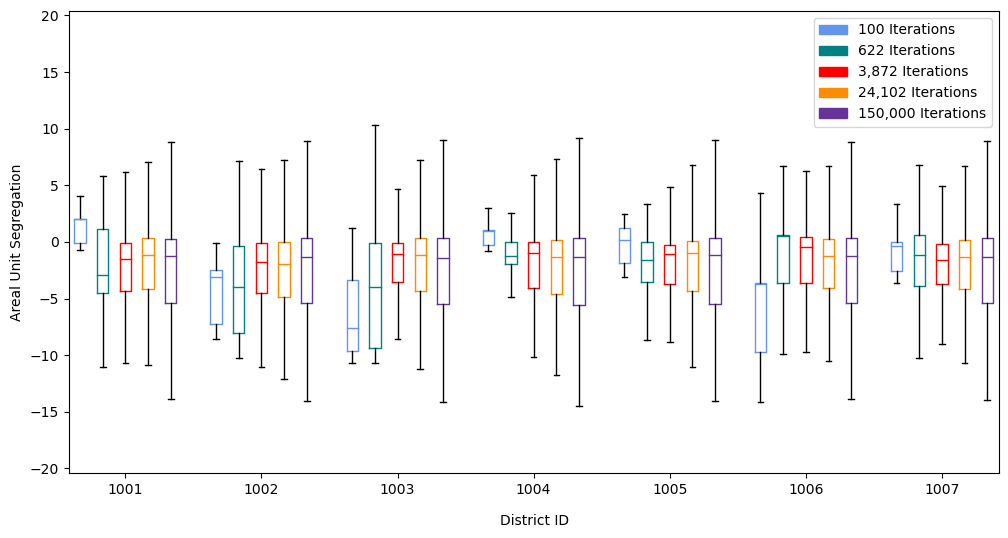

In [48]:
# Positions for the boxes. Skip 1 position every district for visual grouping
pos = np.arange(0, n_dists)
box_pos = len(steps)*pos + 1
box_pos += range(len(box_pos))

# Position for the x-axis tick labels (in the middle of each districts group of boxes)
tick_pos = box_pos + (len(steps)+1)/2 - 1


fig, ax = plt.subplots(figsize=(12,6))
# Looping over each subset of data (e.g, 100 trials, 1000 trials, etc.)
for i,s in enumerate(steps):
    data = stats[i]
    # Create the boxplots
    ax.bxp(data, positions = box_pos+i, 
           widths=0.5,
           boxprops = dict(color=colors[i]),
           flierprops = flierprops,
           medianprops = dict(linestyle='-',
                   color=colors[i])
          )

plt.xticks(tick_pos, list(new_data.index), rotation=0)
plt.ylabel('Areal Unit Segregation')
plt.text(19.5,-25,'District ID')
plt.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], loc='upper right')
plt.savefig('convergence_bars')
plt.show()

In [50]:
patch_6 = mpatches.Patch(color='red', label='n Iterations')
patch_7 = mpatches.Patch(color='k', label='n-1 Iterations')

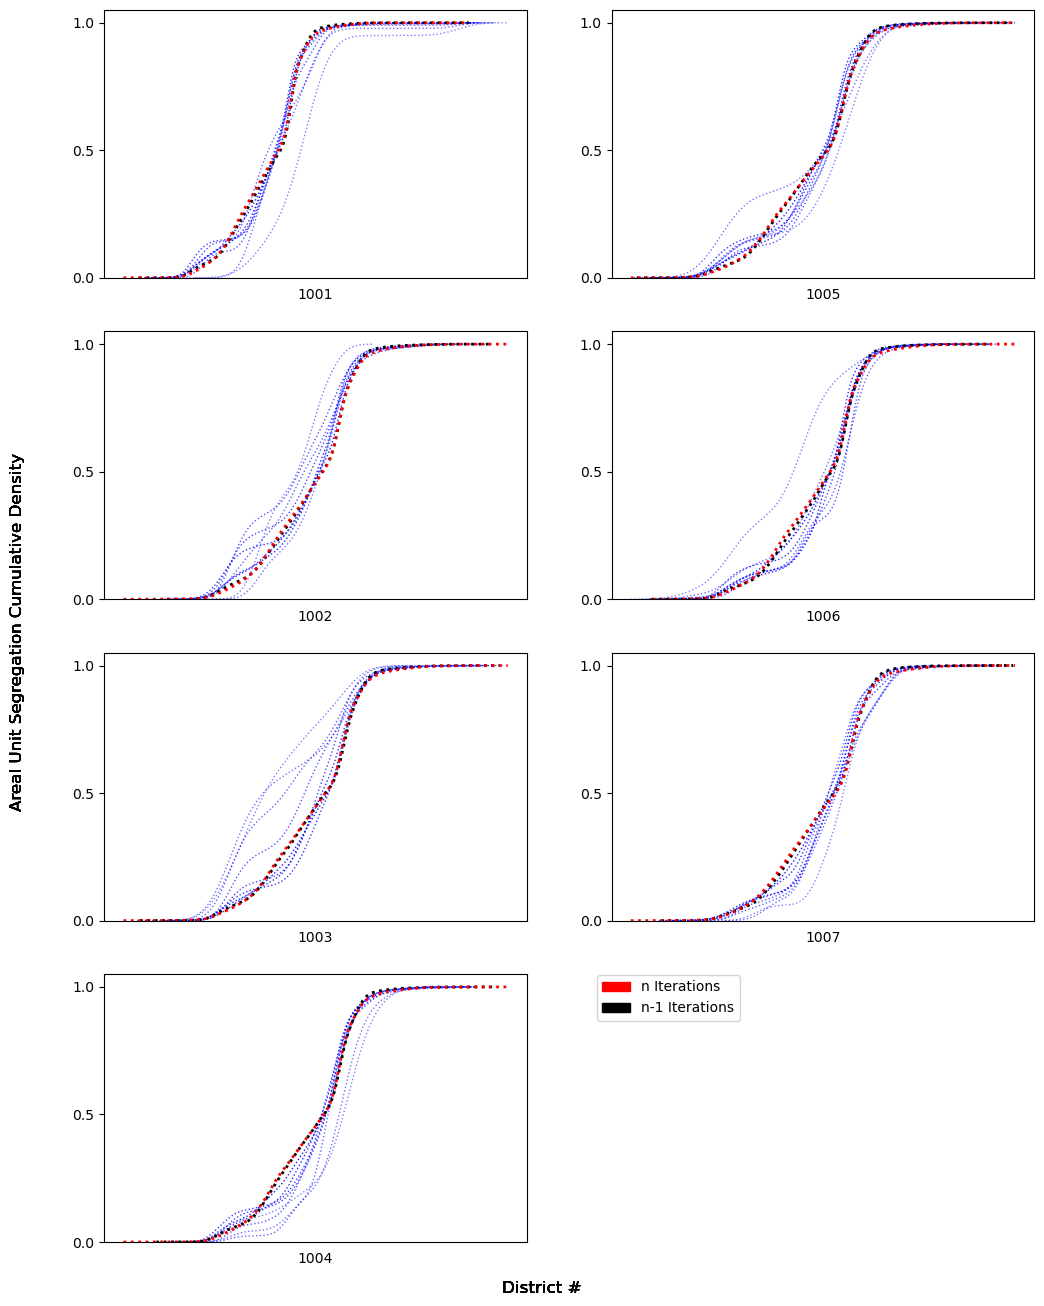

In [68]:
# Showing convergence for individual districts as overlaid cumulative KDE plots
districts = list(new_data.index)

fig, ax = plt.subplots(4,2, figsize=(12,16))
fig.delaxes(ax[3,1])

p=0
q=0

for district in districts:

    temp = new_data.loc[district]
    alphas = np.linspace(0.5, 1, len(kde_steps))

    x = 1

    for i,s in enumerate(kde_steps):
        
        # Show smaller samples as thin blue dotted with varying alpha
        # Show final two as dotted black and dotted red, thick
        
        if i == (len(kde_steps)-1):
            linestyle=':'
            color = 'r'
            linewidth = 2
            alpha = 1
        elif i == (len(kde_steps)-2):
            linestyle=':'
            color = 'k'
            linewidth = 2
            alpha = 1
        else:
            linestyle=':'
            color = 'b'
            linewidth = 1
            alpha = alphas[i]

        sns.kdeplot(temp[0:s], 
                    ax = ax[p,q],
                    color = color, 
                    alpha = alpha, 
                    linestyle = linestyle,
                    linewidth = linewidth, 
                    cumulative=True)

        ax[p,q].set_xticks([])
        ax[p,q].set_yticks([0,.5,1])
        ax[p,q].set_ylabel("")
    
    p+=1

    if p==4:
        p=0
        q=1

    plt.text(15,-.2,'District #',fontsize=12)
    plt.text(-30,1.7,'Areal Unit Segregation Cumulative Density',fontsize=12, rotation='vertical')
    plt.legend(handles=[patch_6, patch_7], bbox_to_anchor=(1.52, .8), loc='lower right')

plt.savefig('convergence districts')
plt.show()

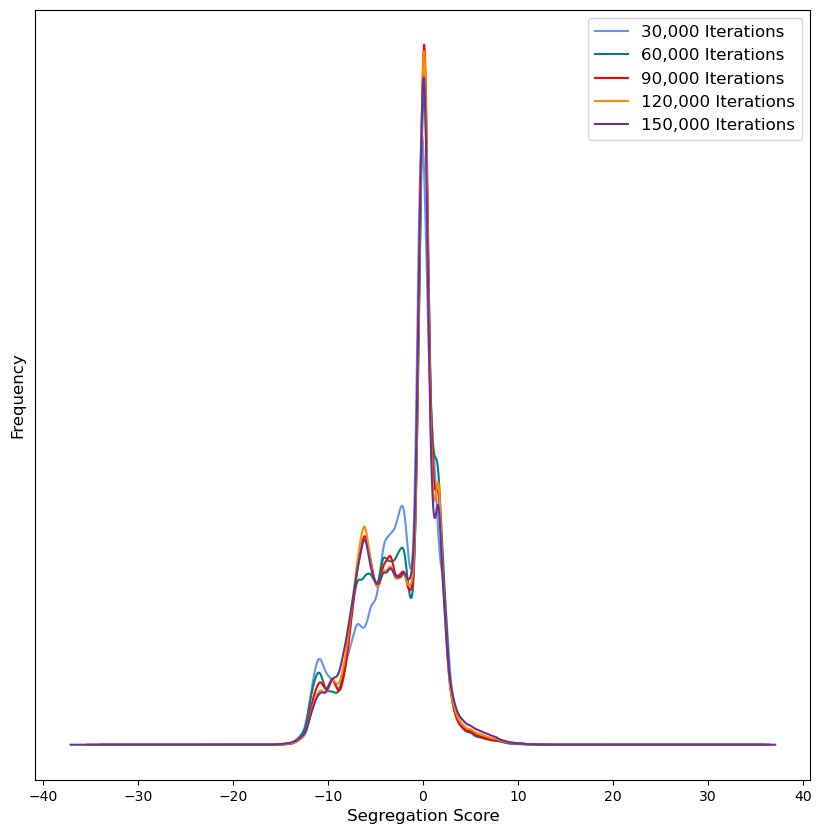

In [69]:
fig1, ax1 = plt.subplots(figsize=(10,10))

#ax1.hist(seg_data.iloc[:,:1000].stack().values, bins=500, rwidth=1, alpha=.3, color="b", label="all", density=True)
pd.DataFrame(new_data.iloc[:,:30000].stack().values).plot(kind='density', ax=ax1, color="cornflowerblue",legend=False)

#x1.hist(seg_data.iloc[:,:5000].stack().values, bins=500, rwidth=1, alpha=.3, color="red", label="all", density=True)
pd.DataFrame(new_data.iloc[:,:60000].stack().values).plot(kind='density', ax=ax1, color="teal",legend=False)

#ax1.hist(seg_data.iloc[:,:7500].stack().values, bins=500, rwidth=1, alpha=.3, color="green", label="all", density=True)
pd.DataFrame(new_data.iloc[:,:90000].stack().values).plot(kind='density', ax=ax1, color="red",legend=False)

#ax1.hist(seg_data.iloc[:,:7500].stack().values, bins=500, rwidth=1, alpha=.3, color="green", label="all", density=True)
pd.DataFrame(new_data.iloc[:,:120000].stack().values).plot(kind='density', ax=ax1, color="darkorange",legend=False)

#ax1.hist(seg_data.stack().values, bins=500, rwidth=1, alpha=.3, color="purple", label="all", density=True)
pd.DataFrame(new_data.stack().values).plot(kind='density', ax=ax1, color="rebeccapurple",legend=False)

plt.legend(labels=["30,000 Iterations", "60,000 Iterations", "90,000 Iterations", "120,000 Iterations", "150,000 Iterations"],
            prop={'size':12})
ax1.set_xlabel("Segregation Score", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.set_yticks([])

plt.savefig("line_compare")
plt.show()



In [72]:
dist_1 = new_data.iloc[:1:]
dist_2 = new_data.iloc[1:2:]
dist_3 = new_data.iloc[2:3:]
dist_4 = new_data.iloc[3:4:]
dist_5 = new_data.iloc[4:5:]
dist_6 = new_data.iloc[5:6:]
dist_7 = new_data.iloc[6:7:]

data = [dist_1.stack().values,
         dist_2.stack().values,
         dist_3.stack().values,
         dist_4.stack().values,
         dist_5.stack().values,
         dist_6.stack().values,
         dist_7.stack().values]

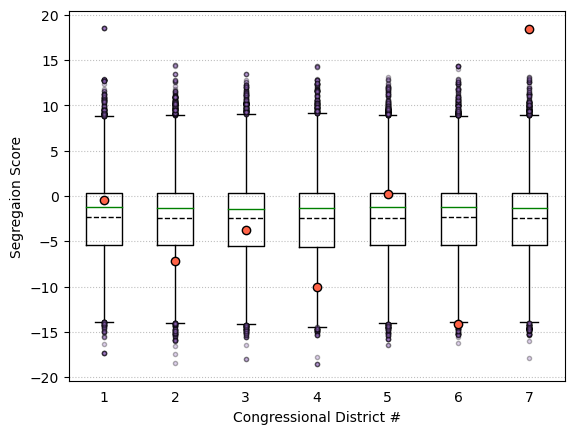

In [73]:
fig, ax = plt.subplots(1,1)

ax.boxplot(data, showmeans=True, meanline=True, showfliers=True,
            flierprops = {'marker':'.',"markerfacecolor":"C4", "markeredgecolor": None, "alpha": .3},
            medianprops ={'color':'green'},
            meanprops = {'color': "black"})

ax.scatter(np.linspace(1,7,num=7), original_sores, c='tomato', edgecolors = 'black', zorder=10)

plt.xlabel("Congressional District #")
plt.ylabel("Segregaion Score")
plt.tick_params(axis='x',bottom=False)
#plt.ylim((-12,12))

ax.grid(which='major', axis='y', linestyle=':', color='gray', alpha=0.5)

plt.savefig(fname='150k_whiskers')
plt.show()

/var/folders/25/yq9cvx4n7714ymc6mt488mw80000gn/T/ipykernel_51825/306179983.py:27: UserWarning: The label '_Hidden Label' of <matplotlib.lines.Line2D object at 0x1649fc400> starts with '_'. It is thus excluded from the legend.
  plt.legend(["GerryChain","_Hidden Label","ALARM"])


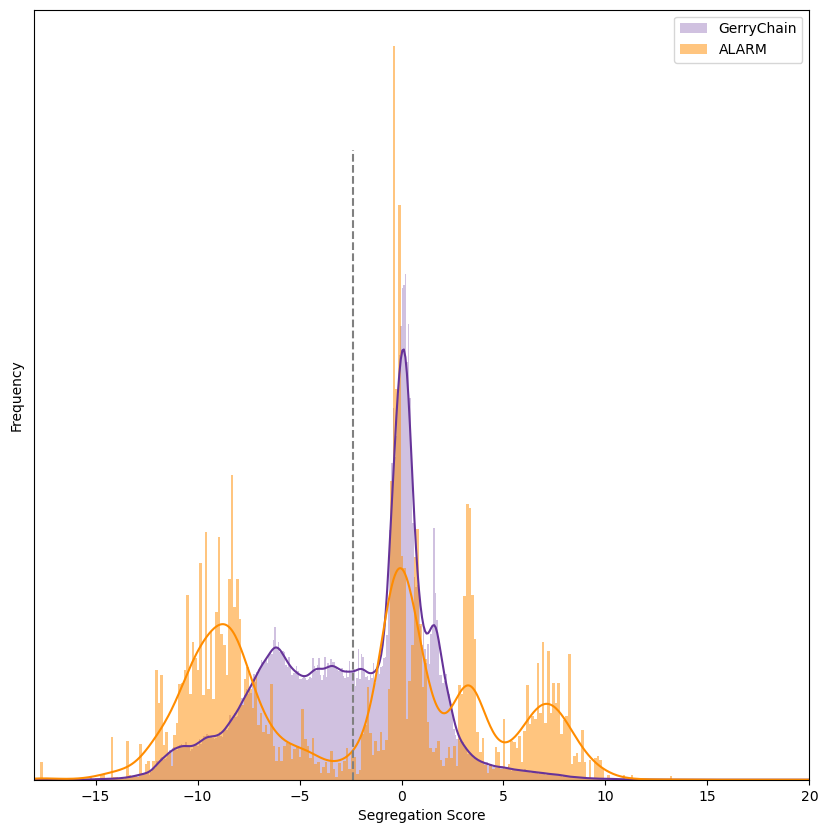

In [74]:
alarm_data = pd.read_csv("/Users/rebeccawagner/Documents/GitHub/GerryGainMCMC/alarm_seg_scores_alabama.csv")["seg_nh_black"]
alarm_data_scores = np.sort(alarm_data.values)
alarm_data_scores

fig, ax = plt.subplots(figsize=(10,10))

ax.hist(seg_scores, bins=500, rwidth=1, alpha=.3, color="rebeccapurple", density=True, label='_Hidden label')
ax = pd.DataFrame(seg_scores).plot(kind='density', ax=ax, color="rebeccapurple",label="GerryChain")

ax.hist(alarm_data_scores, bins=250, rwidth=1, alpha=.5, color="darkorange", density=True, label='_Hidden label')
ax = pd.DataFrame(alarm_data_scores).plot(kind='density', ax=ax, color="darkorange",label="ALARM")
 
#ax.grid(which='major', axis='y', linestyle=':', color='gray', alpha=0.5)

ax.vlines(x=np.mean(seg_scores),ymin=0,ymax=.35, color="grey",linestyle="dashed")


ax.set_xlabel("Segregation Score")
ax.set_ylabel("Frequency")

ax.axes.yaxis.set_ticks([])

#plt.xticks(list(plt.xticks()[0])+ ticks)
plt.xlim((-18,20))


plt.legend(["GerryChain","_Hidden Label","ALARM"])
plt.savefig("hist_compare_3")
plt.show()

In [86]:
q3, q1 = np.percentile(new_data.iloc[6].values, [75 ,25])
q3, q1

(0.3242101095485736, -5.3886069449194025)

In [94]:
test = pd.DataFrame(new_data.iloc[6])
test

,1007
2,-0.531932
3,-0.531932
4,-0.531932
5,-0.531932
6,-0.531932
...,...
149996,0.201735
149997,0.201735
149998,0.201735
149999,-0.553260


In [101]:
id = q1 < test[1007] 

In [104]:
test_2 = test[id]
id_2 = test_2[1007] < q3

In [110]:
random_sample = test_2[id_2].sample(n = 10, axis=0).index
random_sample

Index(['96386',  121026, '37446', '83388', '82916', '79600', '55883', '18468',
        107622,  '7742'],
      dtype='object')

In [114]:
list(random_sample)

['96386',
 121026,
 '37446',
 '83388',
 '82916',
 '79600',
 '55883',
 '18468',
 107622,
 '7742']

In [111]:
file = '/Users/rebeccawagner/Desktop/Csv_100_200_300_400_500_600_700_800_900_100000all'
file_2 = '/Users/rebeccawagner/Desktop/transposed.csv'

In [128]:
with open(file_2) as fd:
    reader=csv.reader(fd)
    interestingrows=[row for idx, row in enumerate(reader) if idx in (96386,121026,37446,83388,82916,79600,55883,18468,107622,7742)]

In [130]:
pd.DataFrame(interestingrows)

,0,1,2,3,4,5,6,7,8,9,...,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844
0,7742,01006,01006,01006,01006,01006,01006,01006,01006,01006,...,01003,01003,01003,01003,01003,01003,01003,01003,01003,01003
1,18468,01006,01006,01006,01006,01006,01006,01006,01006,01006,...,01003,01003,01003,01003,01003,01003,01003,01003,01003,01003
2,37446,01003,01003,01003,01003,01003,01003,01003,01003,01003,...,01003,01003,01003,01001,01003,01001,01003,01003,01003,01003
3,55883,01002,01002,01002,01002,01002,01002,01002,01002,01002,...,01006,01006,01006,01006,01006,01006,01006,01006,01006,01006
4,79600,01006,01006,01006,01006,01006,01006,01006,01006,01006,...,01006,01006,01006,01006,01006,01006,01006,01006,01006,01006
5,82916,01007,01007,01007,01007,01007,01007,01007,01007,01007,...,01001,01007,01001,01001,01007,01001,01007,01007,01007,01007
6,83388,01003,01003,01003,01003,01003,01003,01003,01003,01003,...,01005,01005,01005,01005,01005,01005,01005,01005,01003,01003
7,96386,01003,01003,01003,01003,01003,01003,01003,01003,01003,...,01003,01003,01002,01002,01003,01002,01003,01003,01003,01003
